# **Step 1: Load and Preprocess Dataset**

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url, parse_dates=['Date'])

# **Step 2: Prepare Data for RNN**

In [ ]:
# Normalize temperatures
temps = df['Temp'].values.astype(np.float32)
mean = temps.mean()
std = temps.std()
temps = (temps - mean) / std

In [ ]:
# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 7
X, y = create_sequences(temps, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# **Step 3: Build the LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 4: Train the Model**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6120 - val_loss: 0.3974
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4627 - val_loss: 0.3629
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4289 - val_loss: 0.3368
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3909 - val_loss: 0.3082
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3831 - val_loss: 0.3071
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3765 - val_loss: 0.3011
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3758 - val_loss: 0.3056
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3765 - val_loss: 0.3002
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3737 - val_loss: 0.3014
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3502 - val_loss: 0.2990
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3687 - val_loss: 0.3000
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

# **Step 5: Evaluate and Plot Predictions**

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


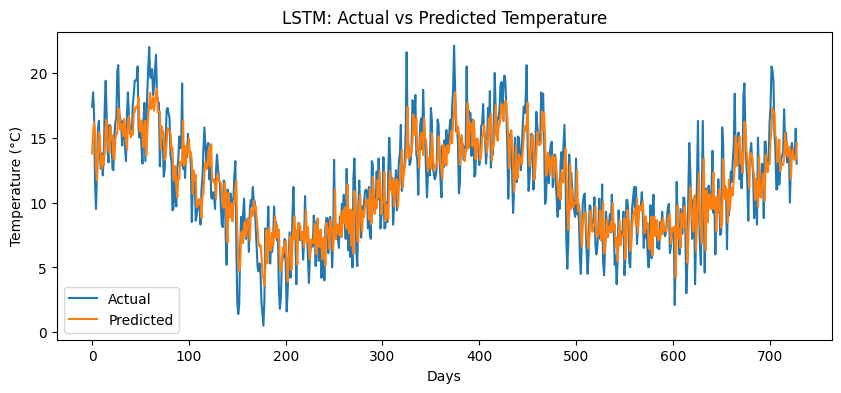

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Denormalize
y_pred_denorm = y_pred * std + mean
y_test_denorm = y_test * std + mean

# Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_denorm, label='Actual')
plt.plot(y_pred_denorm, label='Predicted')
plt.title('LSTM: Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()